Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL06 Neural Network

### Lab Description

This laboratory exercise introduces the implementation of a **fully-connected neural network** from scratch using NumPy, without relying on deep learning frameworks. The lab covers every stage of building a neural network, including parameter initialization, forward propagation, loss computation, backpropagation, and parameter updates. You will apply the model to both binary and multi-class classification problems to understand how neural networks learn from data.

In this hands-on lab, you will preprocess the ``Iris`` dataset for binary classification (setosa vs. versicolor) and the ``EMG`` hand-gesture dataset for multi-class classification, train a neural network on each, and evaluate the results.

### What you can expect to learn

- Theoretical Understanding: Understand the components and workflow of a fully-connected neural network.
- Data Preprocessing: Prepare datasets for binary and multi-class classification tasks.
- Implementation:  
  - Apply He initialization for weight parameters.  
  - Implement numerically stable sigmoid and softmax activation functions.  
  - Use Binary Cross-Entropy (BCE) and Categorical Cross-Entropy (CCE) loss functions.  
  - Derive and implement backpropagation for linear and activation layers.  
  - Train and evaluate the network on different classification problems.

### Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from sklearn import datasets

output = {}

### Required Dataset
Below, we prepare:
1. ``Iris`` (binary) — take 100 samples (setosa vs. versicolor), split into train/val.
2. ``EMG`` (multi-class) — read CSVs from URLs, split into train/val.

In [2]:
# ---- Iris (binary) ----
iris = datasets.load_iris()
X_iris = iris.data[:100].T
y_iris = np.expand_dims(iris.target[:100], axis=1).T

# Train/Val split: 90/10 per class (indices mimic the original script)
X_train_bin = np.concatenate((X_iris[:, :45], X_iris[:, 50:95]), axis=1)
y_train_bin = np.concatenate((y_iris[:, :45], y_iris[:, 50:95]), axis=1)
X_val_bin = np.concatenate((X_iris[:, 45:50], X_iris[:, 95:]), axis=1)
y_val_bin = np.concatenate((y_iris[:, 45:50], y_iris[:, 95:]), axis=1)

print("Iris shapes:")
print("  X_train_bin:", X_train_bin.shape, " y_train_bin:", y_train_bin.shape)
print("  X_val_bin:  ", X_val_bin.shape, " y_val_bin:  ", y_val_bin.shape)

Iris shapes:
  X_train_bin: (4, 90)  y_train_bin: (1, 90)
  X_val_bin:   (4, 10)  y_val_bin:   (1, 10)


In [3]:
# ---- EMG (multi-class, 4 classes) ----
# NOTE: These URLs must be accessible in your environment.
X_train_mc = read_csv(
    "https://raw.githubusercontent.com/ivanlim123/Assignment-3-Backpropagation/main/X_train.csv", header=None
).to_numpy()
y_train_mc = read_csv(
    "https://raw.githubusercontent.com/ivanlim123/Assignment-3-Backpropagation/main/y_train.csv", header=None
).to_numpy()
X_test_mc = read_csv(
    "https://raw.githubusercontent.com/ivanlim123/Assignment-3-Backpropagation/main/X_test.csv", header=None
).to_numpy()

# Split a validation set from the end, as in the original script
X_val_mc = X_train_mc[:, 9000:]
y_val_mc = y_train_mc[:, 9000:]
X_train_mc = X_train_mc[:, :9000]
y_train_mc = y_train_mc[:, :9000]

print("EMG shapes:")
print("  X_train_mc:", X_train_mc.shape, " y_train_mc:", y_train_mc.shape)
print("  X_val_mc:  ", X_val_mc.shape, " y_val_mc:  ", y_val_mc.shape)
print("  X_test_mc: ", X_test_mc.shape)

EMG shapes:
  X_train_mc: (64, 9000)  y_train_mc: (4, 9000)
  X_val_mc:   (64, 342)  y_val_mc:   (4, 342)
  X_test_mc:  (64, 2336)


## Forward propagation module
### Linear Layer
Fully-connected layers, also known as linear layers, connect every input neuron to every output neun. \.
A linear layer performs the transformat:

  $Z = WA +  b$,
where $W$ and $b$ are the weight and bias.

### Initialize parameters
* Step1: 1-layer neural network
Initialize weights using He initialization. \
He initialization helps maintain stable gradients and is commonly used in deep networks.

* Step2: L-layer neural network
Initialize parameters for an L-layer neural network with He initialization.


In [4]:
# Function to initialize parameters for a neural network
def initialize_parameters(n_x, n_y):
    # Set random seed for reproducibility
    np.random.seed(1)

    W1 = np.random.randn(n_y, n_x) * np.sqrt(2 / n_x)
    b1 = np.zeros((n_y, 1)) * np.sqrt(2 / n_x)

    assert W1.shape == (n_y, n_x)
    assert b1.shape == (n_y, 1)

    parameters = {"W1": W1, "b1": b1}

    return parameters

In [5]:
parameters = initialize_parameters(3, 1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))

output["initialize_parameters"] = initialize_parameters(4, 2)

W1 = [[ 1.32627244 -0.49949702 -0.43125043]]
b1 = [[0.]]


In [6]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)

    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2 / layer_dims[l - 1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1)) * np.sqrt(2 / layer_dims[l - 1])

        assert parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layer_dims[l], 1)

    return parameters

In [7]:
parameters = initialize_parameters_deep([5, 4, 3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

output["initialize_parameters_deep"] = initialize_parameters_deep([3, 4, 5])

W1 = [[ 1.02732621 -0.38690873 -0.33404515 -0.67860494  0.54733184]
 [-1.45562088  1.10351585 -0.48142952  0.20177804 -0.15771567]
 [ 0.92471825 -1.30294739 -0.20391454 -0.2428973   0.71705876]
 [-0.69563232 -0.10905317 -0.55520641  0.02669832  0.36860471]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.77825528  0.8094419   0.63752091  0.35531715]
 [ 0.63700135 -0.48346861 -0.08689651 -0.66168891]
 [-0.18942548  0.37501795 -0.48907801 -0.28054711]]
b2 = [[0.]
 [0.]
 [0.]]


### Linear Forward

The linear forward step computes the output of a layer by applying a linear transformation to the input. Specifically, it takes the input activations from the previous layer and calculates: $Z = WA + b$. This step captures the weighted combination of inputs plus a bias term, preparing the data for the next layer or activation function.

In [8]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert Z.shape == (W.shape[0], A.shape[1])
    cache = (A, W, b)

    return Z, cache

In [9]:
A, W, b = np.array([[0, 0.5, 1], [1, 1.5, 2], [2, 2.5, 3]]), np.array([[0.1, 0.2, 0.3]]), np.array([[1.1]])

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

output["linear_forward"] = linear_forward(
    np.array([[0, -0.5, -1], [1, 1.5, 2], [-2, -2.5, -3]]), np.array([[0.5, 0.3, 0.7]]), np.array([[-1.1]])
)

Z = [[1.9 2.2 2.5]]


### Activation Function Layer

In this part, you'll implement commonly used **activation functions**, which add non-linearity to the network. We'll focus on three important types: **Sigmoid**, **Softmax**, and **ReLU**.

#### 1. **Sigmoid Function**

The **sigmoid** function maps any input to a value between 0 and 1, which makes it useful for binary classification:

$$
\sigma(Z) =
\begin{cases}
\frac{1}{1 + e^{-Z}}, & \text{if } Z \geq 0 \\
\frac{e^{Z}}{1 + e^{Z}}, & \text{otherwise}
\end{cases}
$$

⚠️ To avoid overflow when computing exponentials on large negative or positive numbers, we use **numerically stable version**.

#### 2. **Softmax Function**

The **softmax** function turns a vector of values into probabilities that sum to 1, commonly used for multi-class classification:

$$
\sigma(\vec{Z})_i = \frac{e^{Z_i - b}}{\sum_{j=1}^{K} e^{Z_j - b}}, \quad b = \max_j Z_j
$$

⚠️ Without this trick, large values of \$Z\$ can cause overflow errors (e.g., warnings like `overflow encountered in exp`). This implementation ensures numerical safety.

#### 3. **ReLU Function**

The **ReLU (Rectified Linear Unit)** is one of the most popular activation functions in deep learning. It simply outputs the input if it’s positive, and 0 otherwise:

$$
\text{ReLU}(Z) = \max(Z, 0)
$$

It's simple and efficient, helping networks learn faster and avoid vanishing gradients.

Each activation function plays a key role depending on the task:

* Use **Sigmoid** for binary outputs
* Use **Softmax** for multi-class probabilities
* Use **ReLU** in hidden layers for speed and effectiveness


In [10]:
def sigmoid(Z):
    new_Z = Z.ravel()
    A = []
    for i in new_Z:
        if i >= 0:
            A.append(1 / (1 + np.exp(-i)))
        else:
            A.append(np.exp(i) / (1 + np.exp(i)))
    np.array(A).reshape(Z.shape)
    A = np.array([A])

    cache = Z

    return A, cache


def softmax(Z):
    max = np.max(Z)
    A = np.exp(Z - max) / sum(np.exp(Z - max))
    cache = Z

    return A, cache


def relu(Z):
    A = np.maximum(0, Z)
    cache = Z

    assert A.shape == Z.shape

    return A, cache

In [11]:
Z = np.array([[-5, -1, 0, 1, 5]])
A, cache = sigmoid(Z)
print("Sigmoid: A = " + str(A))
output["sigmoid"] = sigmoid(np.array([[-1.82, -0.71, 0.02, 0.13, 2.21]]))

A, cache = relu(Z)
print("ReLU: A = " + str(A))
output["relu"] = relu(np.array([[-1.82, -0.71, 0.02, 0.13, 2.21]]))


Z = np.array([[1, 0, -2], [2, 1, -1], [3, 0, 0], [4, 0, 1]])
A, cache = softmax(Z)
print("Softmax: A = \n" + str(A))
output["softmax"] = softmax(np.array([[0.1, 1.2, -2.1], [2.2, 0.7, -1.3], [1.4, 0.3, 0.2], [3.9, 0.5, -1.6]]))

Sigmoid: A = [[0.00669285 0.26894142 0.5        0.73105858 0.99330715]]
ReLU: A = [[0 0 0 1 5]]
Softmax: A = 
[[0.0320586  0.1748777  0.0320586 ]
 [0.08714432 0.47536689 0.08714432]
 [0.23688282 0.1748777  0.23688282]
 [0.64391426 0.1748777  0.64391426]]


### Model forward
Now we can start to build a forward model.

#### 1. Linear activation forward
To begin with, we should merge the linear transformation and activation function into a single linear-activation layer, as defined by the equation:
$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} + b^{[l]})$,
where $g$ represents the activation function, such as `sigmoid()`, `softmax()`, or `relu()`.


In [12]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])
    cache = (linear_cache, activation_cache)

    return A, cache

In [13]:
A_prev, W, b = (
    np.array([[0.1, -1.2, 1.9], [1.1, 0.2, 2.3], [2.9, -2.5, 3.7]]),
    np.array([[0.1, 0.2, 0.3]]),
    np.array([[-0.5]]),
)

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="relu")
print("With ReLU: A = " + str(A))

A_prev, W, b = (
    np.array([[0.1, -1.2, 1.9], [1.1, 0.2, 2.3], [2.9, -2.5, 3.7]]),
    np.array([[0.1, 0.2, 0.3], [-0.1, -0.2, -0.3], [-0.1, 0, 0.1]]),
    np.array([[-0.5], [0.5], [0.1]]),
)
A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="softmax")
print("With softmax: A = \n" + str(A))

With sigmoid: A = [[0.64565631 0.20915937 0.77902611]]
With ReLU: A = [[0.6  0.   1.26]]
With softmax: A = 
[[0.47535001 0.05272708 0.68692136]
 [0.14317267 0.75380161 0.05526942]
 [0.38147732 0.19347131 0.25780921]]


#### 2. L model forward
For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (linear_activation_forward with `relu()`) $L-1$ times, then follows that with one linear_activation_forward with `sigmoid()` for binary classification or `softmax()` for multi-class classification.

In the code below, the variable AL will denote $A^{[L]} = g(Z^{[L]}) = g(W^{[L]}A^{[L-1]}+b^{[L]})$, where activation function g could be `sigmoid()` for binary classification or `softmax()` for multi-class classification.

**Instruction**:
*   Use the functions you had previously written.
*   Use a for loop to replicate [LINEAR->RELU] (L-1) times.
*   Don't forget to keep track of the caches in the "caches" list. To add a new value c to a list, you can use list.append(c).

**Note**: There are N nodes in the last layer for N-class classification, but only one node for binary classification. Intuitively, this could be pretty confusing sometimes since there should be two nodes in the last layer for binary classification. However, both the one-node(sigmoid, binary cross-entropy) and two-node(softmax, categorical cross-entropy) techniques for binary classification work fine, and picking one technique over the other is a matter of subjective preference. For this assignment, you will implement the former one, which is what we usually do for binary classification.



In [14]:
def L_model_forward(X, parameters, classes):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    if classes == 2:
        AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
        caches.append(cache)
        assert AL.shape == (1, X.shape[1])
    else:
        AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "softmax")
        caches.append(cache)
        assert AL.shape == (classes, X.shape[1])

    return AL, caches

In [15]:
# binary classification
X, parameters, classes = np.array([[0, 1, 2], [-2, -1, 0], [0.5, 0.5, 0.5]]), initialize_parameters_deep([3, 3, 1]), 2
AL, caches = L_model_forward(X, parameters, classes)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

# multi-class classification
X, parameters, classes = np.array([[0, 1, 2], [-2, -1, 0], [0.5, 0.5, 0.5]]), initialize_parameters_deep([3, 3, 10]), 10
AL, caches = L_model_forward(X, parameters, classes)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.07802314 0.01818575 0.00403778]]
Length of caches list = 2
AL = [[6.18255541e-03 7.61028230e-04 7.66374121e-05]
 [2.11940510e-01 2.01651685e-01 1.56962913e-01]
 [1.35096366e-02 2.03338206e-03 2.50381145e-04]
 [2.18485590e-02 6.14321609e-03 1.41311042e-03]
 [2.66899863e-01 4.51947825e-01 6.26088267e-01]
 [1.13256434e-01 1.07946425e-01 8.41707040e-02]
 [7.27765014e-02 3.08118586e-02 1.06721503e-02]
 [2.17220658e-02 4.88048793e-03 8.97083101e-04]
 [4.19482610e-02 1.32235761e-02 3.41028905e-03]
 [2.29915615e-01 1.80600516e-01 1.16058465e-01]]
Length of caches list = 2


### Cost function
In this section, you will implement the cost function. We use binary cross-entropy loss for binary classification and categorical cross-entropy loss for multi-class classification. You need to compute the cost, because you want to check if your model is actually learning. Cross-entropy loss is minimized, where smaller values represent a better model than larger values. A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

#### 1. Binary cross-entropy loss
**Exercise**: Compute the binary cross-entropy cost $J$, using the following formula: (5%) $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

In [16]:
def compute_BCE_cost(AL, Y):
    m = Y.shape[1]
    # Compute loss from aL and y.
    cost = (1 / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))

    cost = np.squeeze(cost)  # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert cost.shape == ()

    return cost

In [17]:
AL, Y = np.array([[0.9, 0.6, 0.4, 0.1, 0.2, 0.8]]), np.array([[1, 1, 1, 0, 0, 0]])

print("cost = " + str(compute_BCE_cost(AL, Y)))
output["compute_BCE_cost"] = compute_BCE_cost(
    np.array([[0.791, 0.983, 0.654, 0.102, 0.212, 0.091, 0.476, 0.899]]), np.array([[1, 1, 1, 1, 0, 0, 0, 0]])
)

cost = 0.5784031417840181


#### 2. Categorical cross-entropy loss
**Exercise**: Compute the categorical cross-entropy cost $J$, using the following formula: (5%) $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right))$$

In [18]:
def compute_CCE_cost(AL, Y):
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = -(1.0 / m) * np.sum(Y * np.log(AL))

    cost = np.squeeze(cost)  # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert cost.shape == ()

    return cost

In [19]:
AL, Y = (
    np.array([[0.8, 0.6, 0.4, 0.1, 0.2, 0.4], [0.1, 0.3, 0.5, 0.7, 0.1, 0.1], [0.1, 0.1, 0.1, 0.2, 0.7, 0.5]]),
    np.array([[1, 1, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, 1]]),
)
print("cost = " + str(compute_CCE_cost(AL, Y)))

cost = 0.472268904012926


### Backward propagation module
In this section, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters.

A quick revision for backpropapagation:

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/6ebc4d60a90c1592aee3eaa3113eb4b37d9b4b19/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%204/Building%20your%20Deep%20Neural%20Network%20-%20Step%20by%20Step/images/backprop_kiank.png" height="200"/>

Similar to forward propagation, you are going to build the backward propagation in three steps:
*   LINEAR backward
*   LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU, sigmoid or softmax activation
*   [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID/SOFTMAX backward (whole model)

#### 1. Linear backward
For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)} $$$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$

**Exercise**: Use the 3 formulas above to implement `linear_backward()`.









In [20]:
def linear_backward(dZ, cache):
    # Here cache is "linear_cache" containing (A_prev, W, b) coming from the forward propagation in the current layer
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db

In [21]:
# Set up some test inputs
dZ, linear_cache = (
    np.array([[1.5, 2.5], [0.5, 1.0]]),
    (np.array([[0.5, 1]]), np.array([[2.0], [1.0]]), np.array([[0.5], [1.0]])),
)

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print("dA_prev = " + str(dA_prev))
print("dW = " + str(dW))
print("db = " + str(db))

dA_prev = [[3.5 6. ]]
dW = [[1.625]
 [0.625]]
db = [[2.  ]
 [0.75]]


#### 2. Linear-Activation backward
Next, you will create a function that merges the two helper functions: `linear_backward()` and the backward step for the activation `linear_activation_backward()`.

First, you will need to implement the backward functions of `sigmoid()`, `relu()` and `softmax()`+`compute_CCE_cost`.

**Exercise**: Implement backward function. (10%+5%) (basic: Sigmoid and ReLU, bonus: Softmax+CCE_loss)

**Instruction**:
*   sigmoid_backward: Implements the backward propagation for SIGMOID unit.
*   relu_backward: Implements the backward propagation for RELU unit.
*   softmax_CCE_backward: Implements the backward propagation for [SOFTMAX->LOSS] unit.

If $g(.)$ is the activation function, sigmoid_backward, relu_backward and softmax_backward compute$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$

1. The derivative of the sigmoid function is: $$σ^{'}(Z^{[l]}) = σ(Z^{[l]}) (1 - σ(Z^{[l]}))$$. <br>
❗**Important**❗: You should use the numerically stable sigmoid function to prevent the overflow exponential problem.

2. The derivative of the relu function is: $$g'(Z^{[l]}) = \begin{cases}
    1,& \text{if } Z^{[l]}> 0\\
    0,              & \text{otherwise}
\end{cases}$$

3. TLDR😉: The derivative of the categorical cross-entropy loss with respect to the last hidden layer is: $$\frac{\partial \mathcal{L}}{\partial Z} = s - y $$. <br> The derivative of the softmax function is: $$\frac{\partial S(z_i)}{\partial z_j} = \begin{cases}
    S(z_i) \times (1 - S(z_i)),& \text{if } i = j\\
    -S(z_i) \times S(z_j),              & \text{if } i \neq j
\end{cases}$$, where $z$ is a vector with shape (number of classes K, 1) and $S(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$. Hence, the real derivative of softmax function would be a full Jacobian matrix. For the special case, K = 4, we have <img src="https://miro.medium.com/max/554/1*SWfgFQLDIPXDf1C6CHmr8A.png" height="100"/>. <br> It is quite complicated to calculate the softmax derivative on its own. However, if you use the softmax and the cross entropy loss, that complexity fades away. Since the softmax layer is usually used at the output, we can actually calculate the derivative of the categorical cross-entropy loss with respect to the n-th node in the last hidden layer. Instead of a long clunky formula, you end up with this terse, easy to compute thing: $$\frac{\partial \mathcal{L}}{\partial Z_i} = s_i - y_i $$, where $s$ is the output of the softmax function and the $y$ is the true label vector(one-hot vector). For more information, you can refer to this article [Derivative of the Softmax Function and the Categorical Cross-Entropy Loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1). <br>
❗**Important**❗: The above mathematical derivation is based on naive implementation. In order to deal with the exponential overflow problem, we should use the normalized exponential function when counting $s$. For the sake of simplicity, we just use the same gradient equation as the naive implementation.






In [22]:
def sigmoid_backward(dA, cache):
    Z = cache
    new_Z = Z.ravel()
    A = []
    for i in new_Z:
        if i >= 0:
            A.append(1 / (1 + np.exp(-i)))
        else:
            A.append(np.exp(i) / (1 + np.exp(i)))
    np.array(A).reshape(Z.shape)
    A = np.array([A])
    dZ = dA * A * (1 - A)

    assert dZ.shape == Z.shape

    return dZ


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    dZ[Z <= 0] = 0  # When z <= 0, you should set dz to 0 as well.

    assert dZ.shape == Z.shape

    return dZ


def softmax_CCE_backward(Y, cache):
    Z = cache
    max = np.max(Z)
    A = np.exp(Z - max) / sum(np.exp(Z - max))
    dZ = A - Y

    assert dZ.shape == Z.shape

    return dZ

In [23]:
dA, cache = np.array([[-2, -1.37, -1.14, -2, -3.72]]), np.array([[0, 1, 2, 0, 1]])
dZ = sigmoid_backward(dA, cache)
print("Sigmoid: dZ = " + str(dZ))

dA, cache = np.array([[-2, -1.37, -1.14], [1.7, 2, 3.72]]), np.array([[-2, -1, 2], [1, 0, 1]])
dZ = relu_backward(dA, cache)
print("ReLU: dZ = " + str(dZ))

Y, cache = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), np.array([[-2, -1, -2], [1, 0, -2], [0, 1, 2]])
dZ = softmax_CCE_backward(Y, cache)
print("Softmax: dZ = " + str(dZ))
output["softmax_CCE_backward"] = softmax_CCE_backward(
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    np.array([[-2.11, -1.22, -2.33], [1.44, 0.55, -2.66], [0.77, 1.88, 2.99]]),
)

Sigmoid: dZ = [[-0.5        -0.26935835 -0.11969269 -0.5        -0.73139639]]
ReLU: dZ = [[ 0.    0.   -1.14]
 [ 1.7   0.    3.72]]
Softmax: dZ = [[-0.96488097  0.09003057  0.01766842]
 [ 0.70538451 -0.75527153  0.01766842]
 [ 0.25949646  0.66524096 -0.03533684]]


In [24]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [25]:
dAL, linear_activation_cache = (
    np.array([[-2, -1.37, -1.14, -2, -3.72]]),
    (
        (np.array([[-2, -1, 0, 1, 2], [2, 1, 0, -1, -2]]), np.array([[2.0, 1.0]]), np.array([[0.5]])),
        np.array([[0, 1, 2, 0, 1]]),
    ),
)
dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation="sigmoid")
print("sigmoid:")
print("dA_prev = " + str(dA_prev))
print("dW = " + str(dW))
print("db = " + str(db) + "\n")

dAL, linear_activation_cache = (
    np.array([[-2, -1.37, -1.14], [1.7, 2, 3.72]]),
    (
        (np.array([[-2, -1, 0], [2, 1, 0], [0, 1, 2]]), np.array([[-2, -1, 0], [2, 1, 0]]), np.array([[0.5], [-0.5]])),
        np.array([[-2, -1, 2], [1, 0, 1]]),
    ),
)
dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation="relu")
print("relu:")
print("dA_prev = " + str(dA_prev))
print("dW = " + str(dW))
print("db = " + str(db))

sigmoid:
dA_prev = [[-1.         -0.5387167  -0.23938537 -1.         -1.46279278]
 [-0.5        -0.26935835 -0.11969269 -0.5        -0.73139639]]
dW = [[-0.13868689  0.13868689]]
db = [[-0.42408949]]

relu:
dA_prev = [[3.4  0.   9.72]
 [1.7  0.   4.86]
 [0.   0.   0.  ]]
dW = [[ 0.          0.         -0.76      ]
 [-1.13333333  1.13333333  2.48      ]]
db = [[-0.38      ]
 [ 1.80666667]]


#### 3 - L-Model Backward
Now you will implement the backward function for the whole network. Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. Figure below shows the backward pass.

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/6ebc4d60a90c1592aee3eaa3113eb4b37d9b4b19/C1%20-%20Neural%20Networks%20and%20Deep%20Learning/Week%204/Building%20your%20Deep%20Neural%20Network%20-%20Step%20by%20Step/images/mn_backward.png" height="400"/>

Initializing backpropagation: To backpropagate through this network, we know that the output is, $A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute dAL $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$. To do so, use this formula (derived using calculus which you don't need in-depth knowledge of):
```
dAL = - (np.divide(Y, AL + ϵ) - np.divide(1 - Y, 1 - AL + ϵ)) # derivative of cost with respect to AL, where ϵ = 1e-5 is added to prevent zero division.
```


You can then use this post-activation gradient dAL to keep going backward. As seen in figure above, you can now feed in dAL into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a for loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula :

$$grads["dW" + str(l)] = dW^{[l]} $$
For example, for $l=3$ this would store $dW^{[l]}$ in grads["dW3"].


In [26]:
def L_model_backward(AL, Y, caches, classes):
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL

    if classes == 2:
        # Initializing the backpropagation
        dAL = -(np.divide(Y, AL + 1e-5) - np.divide(1 - Y, 1 - AL + 1e-5))

        # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
        current_cache = caches[L - 1]  # Last Layer
        grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
            dAL, current_cache, "sigmoid"
        )
    else:
        # Initializing the backpropagation
        linear_cache, activation_cache = caches[L - 1]  # Last Layer
        dZ = softmax_CCE_backward(Y, activation_cache)

        # Lth layer (LINEAR) gradients. Inputs: "dZ, linear_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
        grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZ, linear_cache)

    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l + 1)], current_cache, activation="relu"
        )
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [27]:
# binary classification
X, parameters, classes = np.array([[0, 1, 2], [-2, -1, 0], [0.5, 0.5, 0.5]]), initialize_parameters_deep([3, 3, 1]), 2
AL, caches = L_model_forward(X, parameters, classes)
Y_assess = np.array([[1, 0, 0]])
grads = L_model_backward(AL, Y_assess, caches, classes)
print("Binary classification")
print("dW1 = " + str(grads["dW1"]))
print("db1 = " + str(grads["db1"]))
print("dA1 = " + str(grads["dA1"]) + "\n")

# multi-class classification
X, parameters, classes = np.array([[0, 1, 2], [-2, -1, 0], [0.5, 0.5, 0.5]]), initialize_parameters_deep([3, 3, 3]), 3
AL, caches = L_model_forward(X, parameters, classes)
Y_assess = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
grads = L_model_backward(AL, Y_assess, caches, classes)
print("Multi-class classification")
print("dW1 = " + str(grads["dW1"]))
print("db1 = " + str(grads["db1"]))
print("dA1 = " + str(grads["dA1"]))

Binary classification
dW1 = [[-0.00178234 -0.12389888  0.03052914]
 [ 0.          0.          0.        ]
 [-0.01472455 -1.0235744   0.25221246]]
db1 = [[0.06105827]
 [0.        ]
 [0.50442493]]
dA1 = [[ 1.87699706e-01 -3.70276293e-03 -8.22125021e-04]
 [-1.10052058e+00  2.17100329e-02  4.82028195e-03]
 [ 1.55065655e+00 -3.05898912e-02 -6.79187823e-03]]

Multi-class classification
dW1 = [[ 0.42051843  0.06541362  0.0887762 ]
 [ 0.          0.          0.        ]
 [ 1.08372031 -1.61959581  0.67582903]]
db1 = [[0.1775524 ]
 [0.        ]
 [1.35165806]]
dA1 = [[-0.09507462 -0.00609164  0.63382346]
 [-1.45707343  0.00732963 -0.17178251]
 [ 2.4424153  -0.02604318  1.63860206]]


### Update parameters
In this section you will update the parameters of the model, using gradient descent:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$
where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary.

**Exercise**: Implement update_parameters() to update your parameters using gradient descent.

**Instructions**:
*   Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$.


In [28]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

In [29]:
np.random.seed(1)
parameters, grads = (
    {"W1": np.random.rand(3, 4), "b1": np.random.rand(3, 1), "W2": np.random.rand(1, 3), "b2": np.random.rand(1, 1)},
    {
        "dW1": np.random.rand(3, 4),
        "db1": np.random.rand(3, 1),
        "dW2": np.random.rand(1, 3),
        "db2": np.random.rand(1, 1),
    },
)
parameters = update_parameters(parameters, grads, 0.1)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

np.random.seed(1)
output["update_parameters"] = update_parameters(
    {
        "W1": np.random.randn(3, 4),
        "b1": np.random.randn(3, 1),
        "W2": np.random.randn(1, 3),
        "b2": np.random.randn(1, 1),
    },
    {
        "dW1": np.random.randn(3, 4),
        "db1": np.random.randn(3, 1),
        "dW2": np.random.randn(1, 3),
        "db2": np.random.randn(1, 1),
    },
    0.075,
)

W1 = [[ 0.39721186  0.64025004 -0.09671178  0.27099015]
 [ 0.07752363  0.00469968  0.09679955  0.33705631]
 [ 0.392862    0.52183369  0.33138026  0.67538482]]
b1 = [[ 0.16234149]
 [ 0.78232848]
 [-0.02592894]]
W2 = [[0.6012798  0.38575324 0.49003974]]
b2 = [[0.05692437]]


### Basic implementation (binary classification)

Congratulations on implementing all the functions by yourself. You have done an incredible job! 👏

Now you have all the tools you need to get started with classification. In this section, you will build a binary classifier using the functions you had previously written. You will create a model that can classify the different species of the Iris flower. The Iris dataset consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. However, you only need to classify Iris setosa and Iris versicolor in this exercise.

**Exercise**: Implement a binary classifier and tune hyperparameter.

**Instruction**:
*   Train a model with validation accuracy higher than 80%.



In [30]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, classes=2):
    np.random.seed(1)
    costs = []  # keep track of cost

    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID/SOFTMAX.
        AL, caches = L_model_forward(X, parameters, classes)

        # Compute cost.
        if classes == 2:
            cost = compute_BCE_cost(AL, Y)
        else:
            cost = compute_CCE_cost(AL, Y)

        # Backward propagation.
        grads = L_model_backward(AL, Y, caches, classes)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iterations (per hundreds)")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

#### Training

Cost after iteration 0: 1.808758
Cost after iteration 100: 0.646826
Cost after iteration 200: 0.423764
Cost after iteration 300: 0.304835
Cost after iteration 400: 0.234744
Cost after iteration 500: 0.189654
Cost after iteration 600: 0.158602
Cost after iteration 700: 0.136072
Cost after iteration 800: 0.119049
Cost after iteration 900: 0.105767
Cost after iteration 1000: 0.095133
Cost after iteration 1100: 0.086437
Cost after iteration 1200: 0.079198
Cost after iteration 1300: 0.073081
Cost after iteration 1400: 0.067847
Cost after iteration 1500: 0.063319
Cost after iteration 1600: 0.059362
Cost after iteration 1700: 0.055877
Cost after iteration 1800: 0.052783
Cost after iteration 1900: 0.050019
Cost after iteration 2000: 0.047534
Cost after iteration 2100: 0.045289
Cost after iteration 2200: 0.043250
Cost after iteration 2300: 0.041390
Cost after iteration 2400: 0.039686
Cost after iteration 2500: 0.038120
Cost after iteration 2600: 0.036676
Cost after iteration 2700: 0.035339
Cost

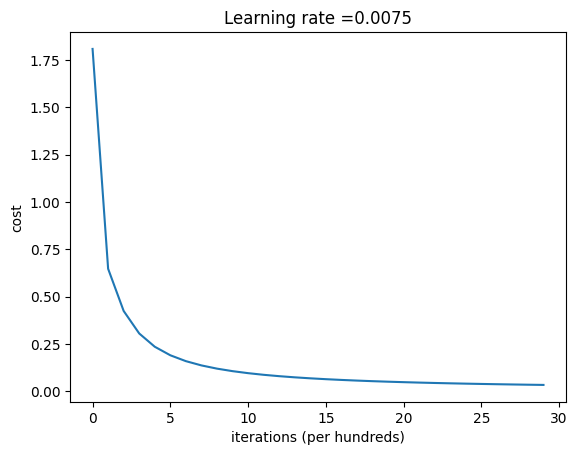

In [31]:
# Use Iris Dataset
layers_dims = [4, 1]
parameters = L_layer_model(
    X_train_bin, y_train_bin, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=True, classes=2
)

#### Results

In [32]:
def predict(X, y, parameters, classes):
    """
    Predicts the output of a neural network given input data and parameters.
    Args:
        X: Input data (features).
        y: True labels (optional, for accuracy calculation).
        parameters: Parameters of the neural network.
        classes: Number of classes in the output, 2 for binary classification, greater than 2 for multi-class classification.
    Returns:
        p: predictions for the given dataset X.
    """
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network

    # Initialize predictions
    p = np.zeros((1, m)) if classes == 2 else np.zeros((classes, m))

    # Forward propagation
    probas, _ = L_model_forward(X, parameters, classes)

    if classes == 2:
        # Binary classification: convert probabilities to 0/1 predictions
        p[0, :] = (probas[0, :] > 0.5).astype(int)

        # Print accuracy if true labels are provided
        if y is not None:
            accuracy = np.sum((p == y) / m)
            print(f"Accuracy: {accuracy:.2f}")
    else:
        # Multi-class classification: convert probabilities to one-hot predictions
        predictions = np.argmax(probas, axis=0)
        p[predictions, np.arange(m)] = 1

        # Print accuracy if true labels are provided
        if y is not None:
            correct_predictions = np.sum(np.all(p == y, axis=0))
            accuracy = correct_predictions / m
            print(f"Accuracy: {accuracy:.2f}")

    return p

In [33]:
pred_train = predict(X_train_bin, y_train_bin, parameters, 2)
pred_val = predict(X_val_bin, y_val_bin, parameters, 2)

Accuracy: 1.00
Accuracy: 1.00


### Multi class classification

In this section, you need to implement a multi-class classifier using the functions you had previously written. You will create a model that can classify four hand gestures using electromyography (EMG) signals. The EMG signal is a biomedical signal that measures electrical currents generated in muscles during its contraction representing neuromuscular activities.

#### Training

In [ ]:
layers_dims = [64, 256, 32, 256, 4]
parameters = L_layer_model(
    X_train_mc, y_train_mc, layers_dims, learning_rate=0.0075, num_iterations=8000, print_cost=True, classes=4
)

Cost after iteration 0: 3.067374
Cost after iteration 100: 1.344188
Cost after iteration 200: 1.246079
Cost after iteration 300: 1.166323
Cost after iteration 400: 1.087787
Cost after iteration 500: 1.010922
Cost after iteration 600: 0.937790
Cost after iteration 700: 0.869723
Cost after iteration 800: 0.807598
Cost after iteration 900: 0.751395
Cost after iteration 1000: 0.700703
Cost after iteration 1100: 0.654597


#### Results

In [ ]:
pred_train = predict(X_train_mc, y_train_mc, parameters, 4)
pred_val = predict(X_val_mc, y_val_mc, parameters, 4)